Reference https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/09-Nonlinear-Filtering.ipynb

In [1]:
%matplotlib inline

import ipywidgets as wdg
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import scipy
import scipy.stats as stats
import numpy as np
from numpy.random import randn, normal
import matplotlib.pyplot as plt

from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints, JulierSigmaPoints

In [2]:
data = normal(loc=0., scale=1., size=500000)
edata = np.exp(data)

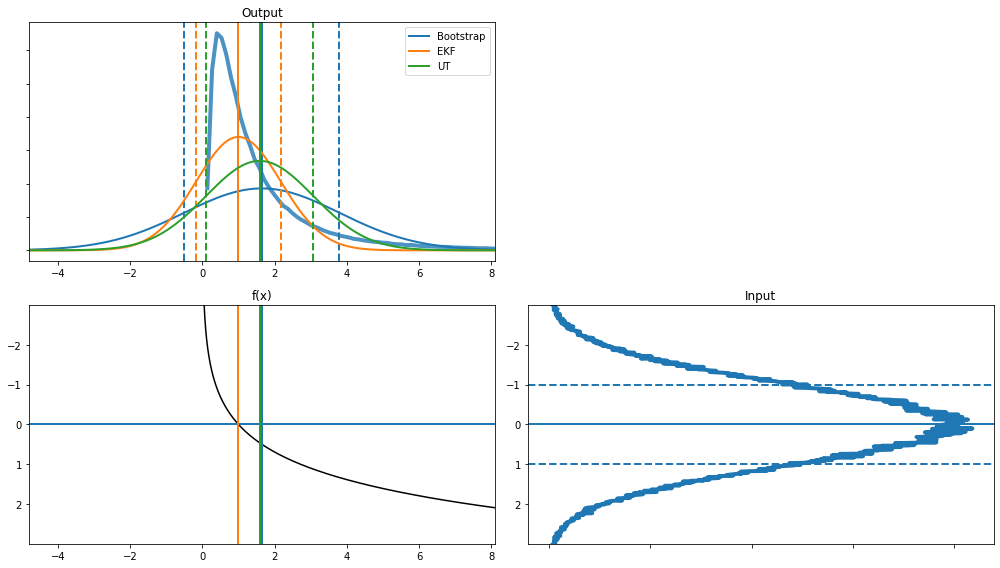

In [3]:
def plot_nonlinear_func(data, f, num_bins=1000, points = JulierSigmaPoints(n=1, kappa=1)):
    
    y = f(data)
    
    x_mean, x_std = np.mean(data), np.std(data)
    y_mean, y_std = np.mean(y), np.std(y)
    in_lims = [x_mean - x_std*3, x_mean + x_std*3]
    out_lims = [y_mean - y_std*3, y_mean + y_std*3]
    
    x_a = np.arange(in_lims[0], in_lims[1], 0.01)
    y_a = np.arange(out_lims[0], out_lims[1], 0.01)
    
    fig, ax = plt.subplots(2, 2, figsize=(14,8))
    ax[0][1].axis('off')
    
    # plot output
    h = np.histogram(y, num_bins, density=True)
    ax[0][0].set_xlim(out_lims[0], out_lims[1])
    ax[0][0].yaxis.set_ticklabels([])
    ax[0][0].set_title('Output')

    
    # Boostrapped distribution 
    ax[0][0].plot(h[1][1:], h[0], lw=4, alpha=0.8)

    # Boostrapped Gaussian
    ax[0][0].plot(y_a, stats.norm.pdf(y_a, y_mean, y_std), color='C0', lw=2, label='Bootstrap')
    ax[0][0].axvline(y_mean, ls='-', color='C0', lw=2)
    ax[0][0].axvline(y_mean - y_std, ls='--', color='C0', lw=2)
    ax[0][0].axvline(y_mean + y_std, ls='--', color='C0', lw=2)

    # EKF Gaussian
    with np.errstate(invalid='ignore'):
        dfdx = scipy.misc.derivative(f, x_mean)
        ekf_mean = f(x_mean)
        ekf_std = np.sqrt(dfdx * x_std * x_std * dfdx) 

    ax[0][0].plot(y_a, stats.norm.pdf(y_a, ekf_mean, ekf_std), color='C1', lw=2, label='EKF')
    ax[0][0].axvline(ekf_mean, ls='-', color='C1', lw=2)
    ax[0][0].axvline(ekf_mean - ekf_std, ls='--', color='C1', lw=2)
    ax[0][0].axvline(ekf_mean + ekf_std, ls='--', color='C1', lw=2)
    
    # Sigma-points Gaussian MerweScaledSigmaPoints, JulierSigmaPoints
    sigmas = points.sigma_points(x_mean, x_std)
    with np.errstate(invalid='ignore'):
        sigmas_f = np.array([f(sigma) for sigma in sigmas])
        if np.isnan(sigmas_f).any():
            print ("Some of sigma points outside of the function domain")
    ut_mean, ut_cov = unscented_transform(sigmas_f, points.Wm, points.Wc)
    ut_std = np.sqrt(ut_cov[0])

    ax[0][0].plot(y_a, stats.norm.pdf(y_a, ut_mean[0], ut_std), color='C2', lw=2, label='UT')
    ax[0][0].axvline(ut_mean, ls='-', color='C2', lw=2)
    ax[0][0].axvline(ut_mean - ut_std, ls='--', color='C2', lw=2)
    ax[0][0].axvline(ut_mean + ut_std, ls='--', color='C2', lw=2)
    
    ax[0][0].legend()
    
    # plot transfer function
    with np.errstate(invalid='ignore'):
        y_f = f(x_a)

    ax[1][0].plot (y_f, x_a, 'k')
    #ax[1][0].scatter(np.mean(ys), x0, c='r', marker='*', s=20, label='Mean')
    ax[1][0].set_xlim(out_lims)
    ax[1][0].set_ylim(in_lims[::-1])
    ax[1][0].set_title('f(x)')
    ax[1][0].axhline(x_mean, ls='-', lw=2)
    ax[1][0].axvline(y_mean, ls='-', lw=2, color='C0')
    ax[1][0].axvline(ekf_mean, ls='-', lw=2, color='C1')
    ax[1][0].axvline(ut_mean, ls='-', lw=2, color='C2')

    # plot input
    h = np.histogram(data, num_bins, density=True)
    ax[1][1].xaxis.set_ticklabels([])
    ax[1][1].set_ylim(in_lims[::-1])
    ax[1][1].set_title('Input')

    ax[1][1].plot(h[0], h[1][1:], lw=4)
    ax[1][1].plot(stats.norm.pdf(x_a, x_mean, x_std), x_a, color='C0', lw=2)
    ax[1][1].axhline(x_mean, ls='-', lw=2)
    ax[1][1].axhline(x_mean - x_std, ls='--', lw=2)
    ax[1][1].axhline(x_mean + x_std, ls='--', lw=2)
    
    fig.tight_layout()
    
plot_nonlinear_func(data, lambda x: np.exp(x))

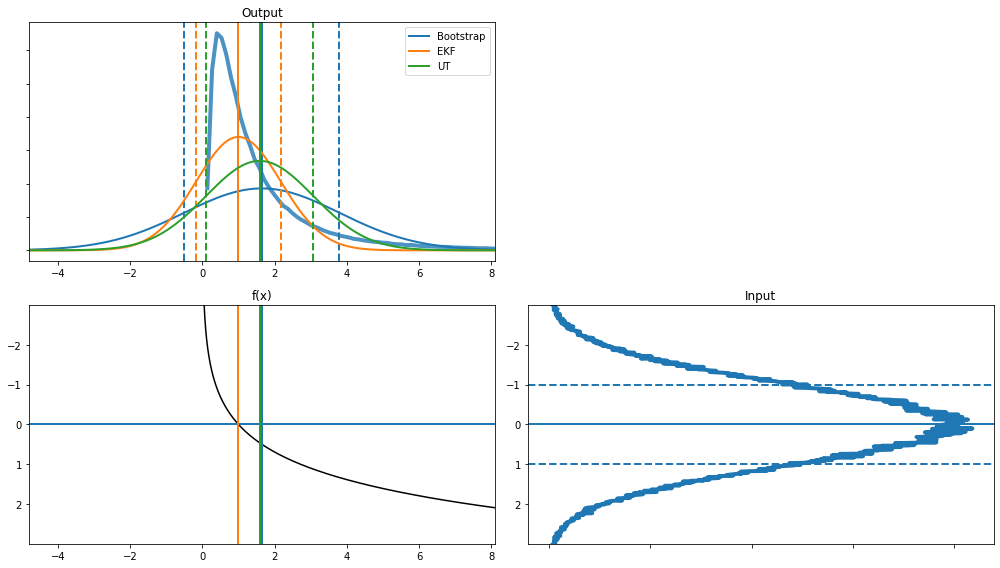

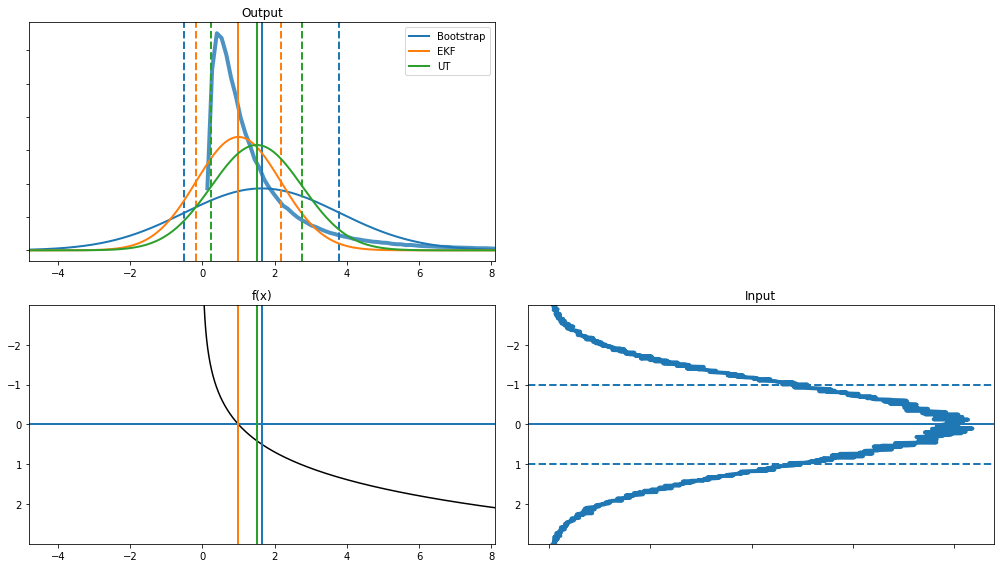

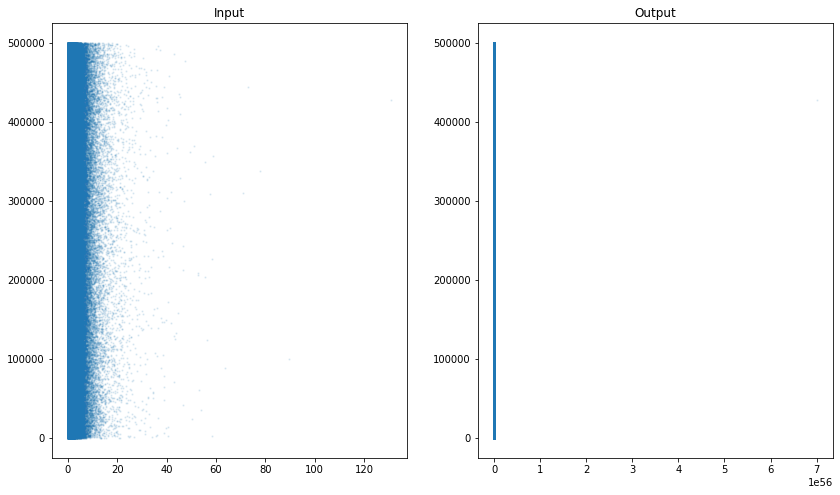

In [4]:
g = lambda x: np.exp(x)
plot_nonlinear_func(data, g, points=JulierSigmaPoints(n=1, kappa=1))
plot_nonlinear_func(data, g, points=MerweScaledSigmaPoints(n=1, alpha=.3, beta=2., kappa=1))

fig, ax = plt.subplots(1, 2, figsize=(14,8))
ax[0].scatter(edata, range(edata.shape[0]), alpha=.1, s=1.5)
ax[0].set_title('Input')
ax[1].scatter(g(edata), range(edata.shape[0]), alpha=.1, s=1.5);
ax[1].set_title('Output');

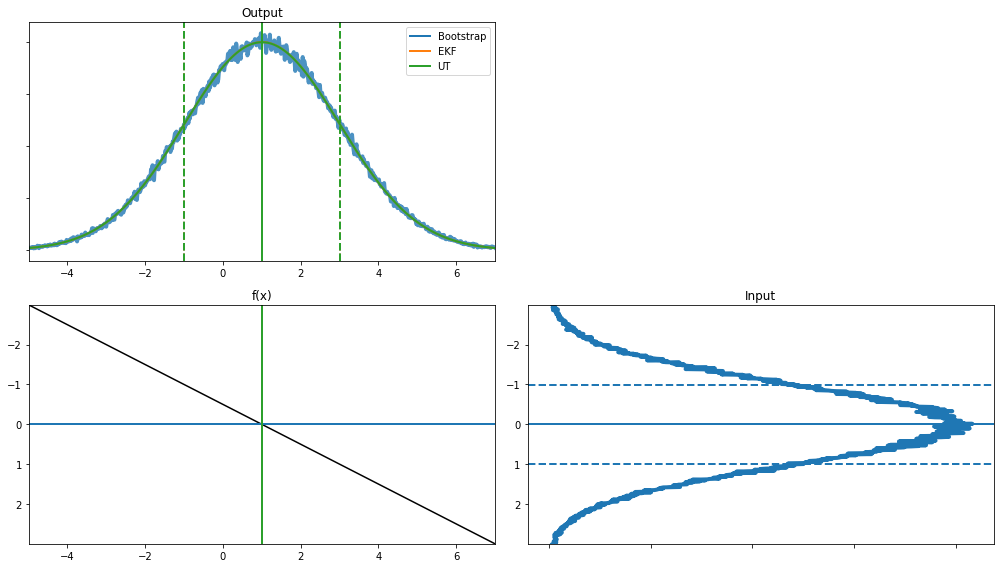

In [5]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: 2*x+1)

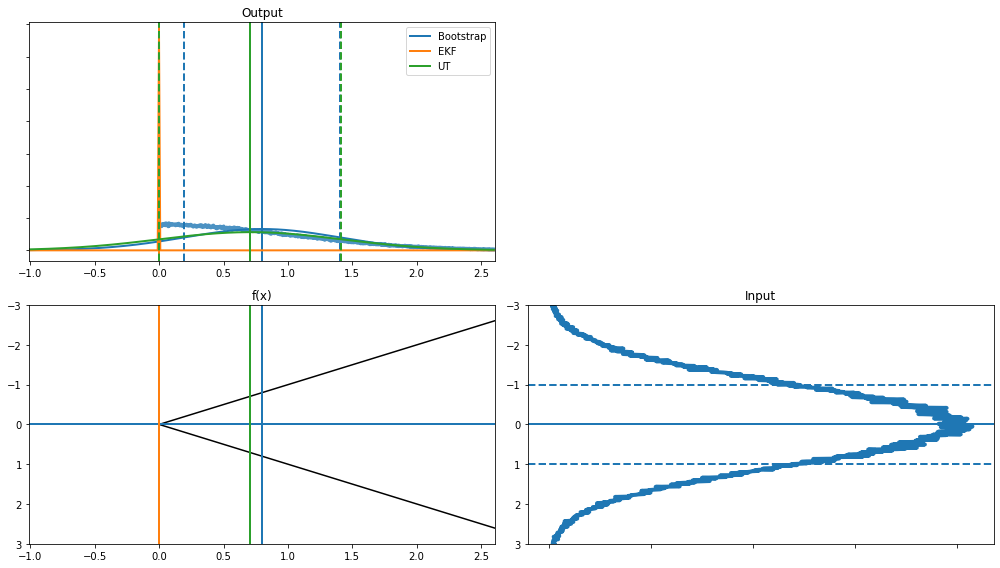

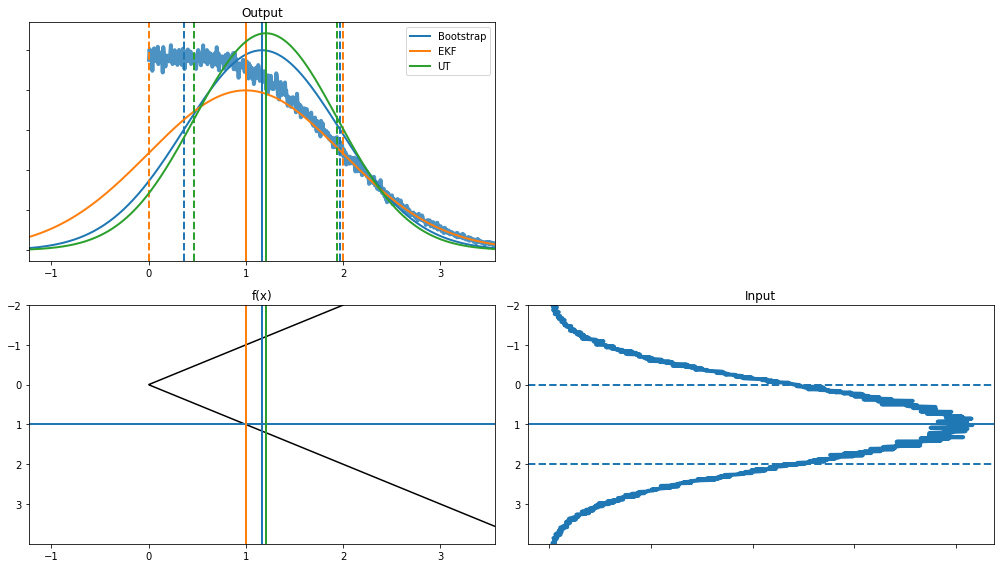

In [6]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.abs(x))
plot_nonlinear_func(normal(loc=1., scale=1., size=500000), lambda x: np.abs(x))

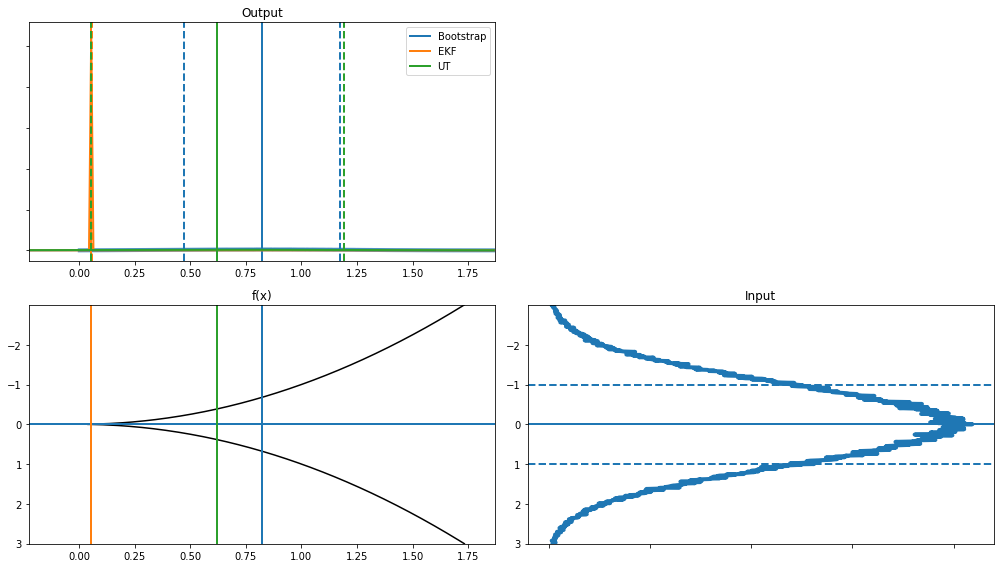

In [7]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.sqrt(np.abs(x)))

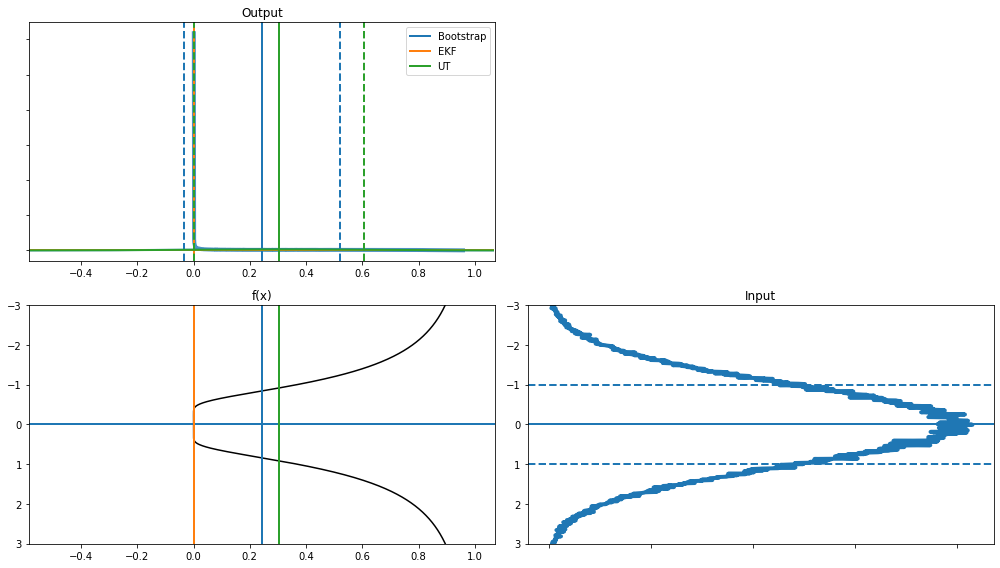

In [8]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.exp(-np.divide(1, x**2)))

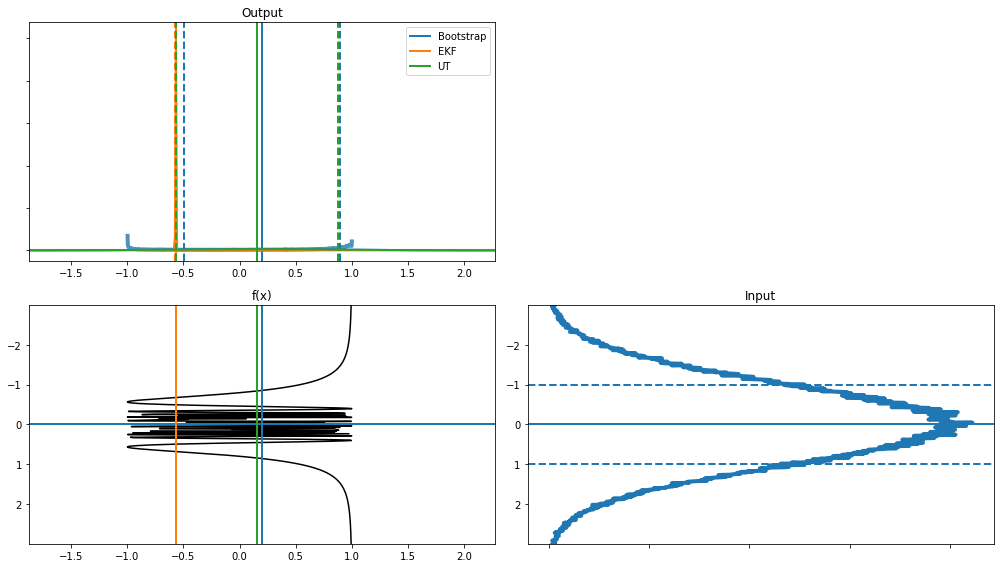

In [9]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.cos(-np.divide(1, x**2)))

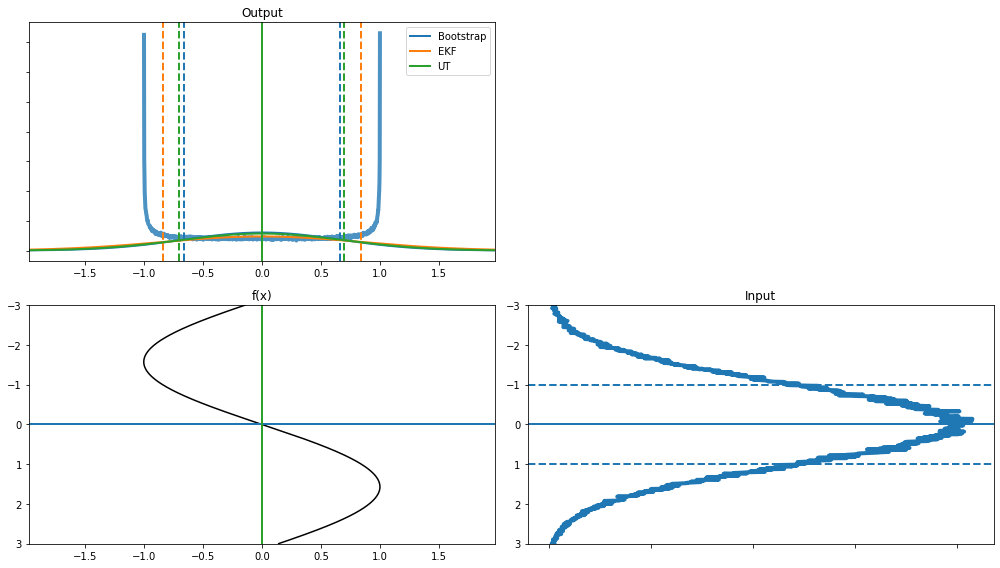

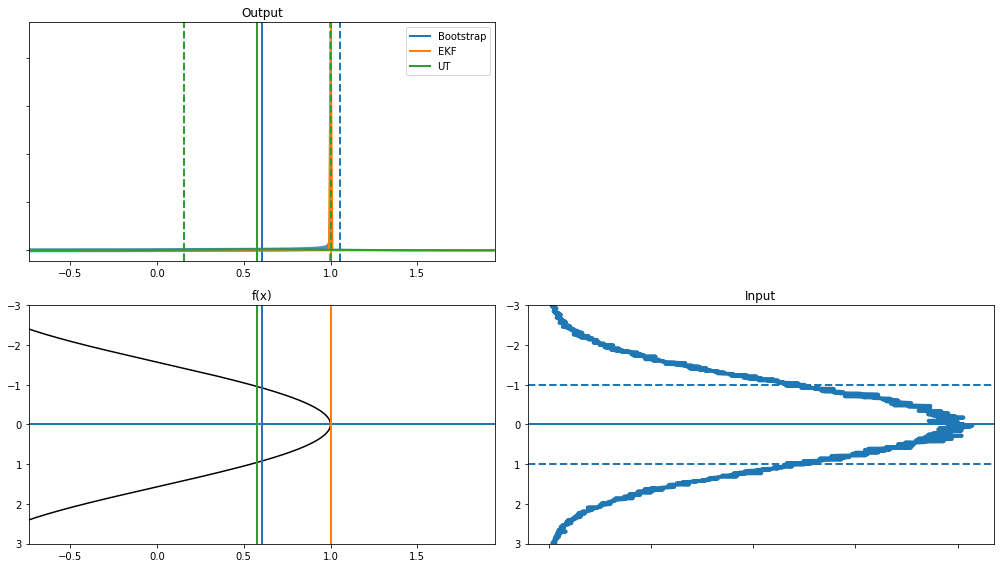

In [10]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.sin(x))
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.cos(x))

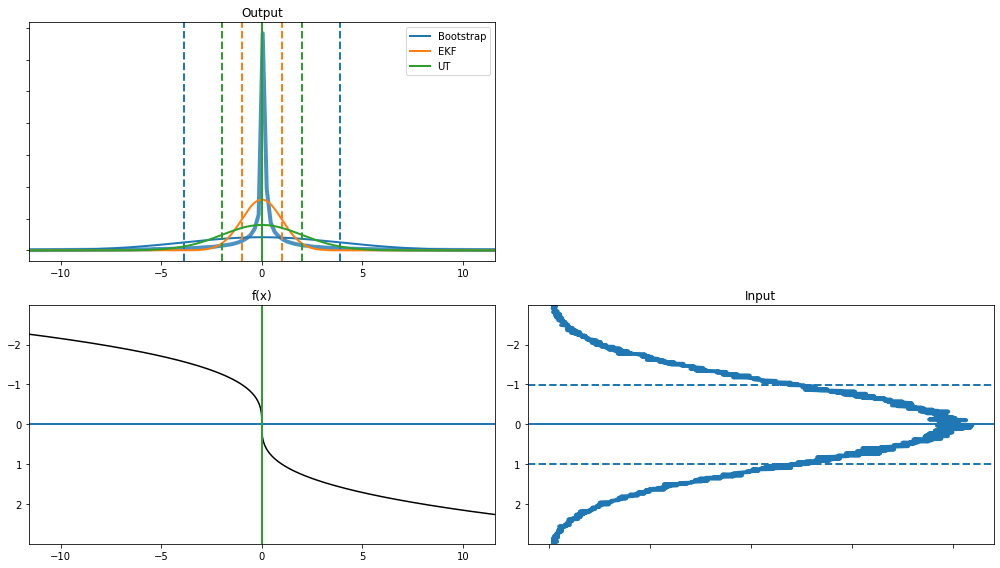

In [11]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: x**3)

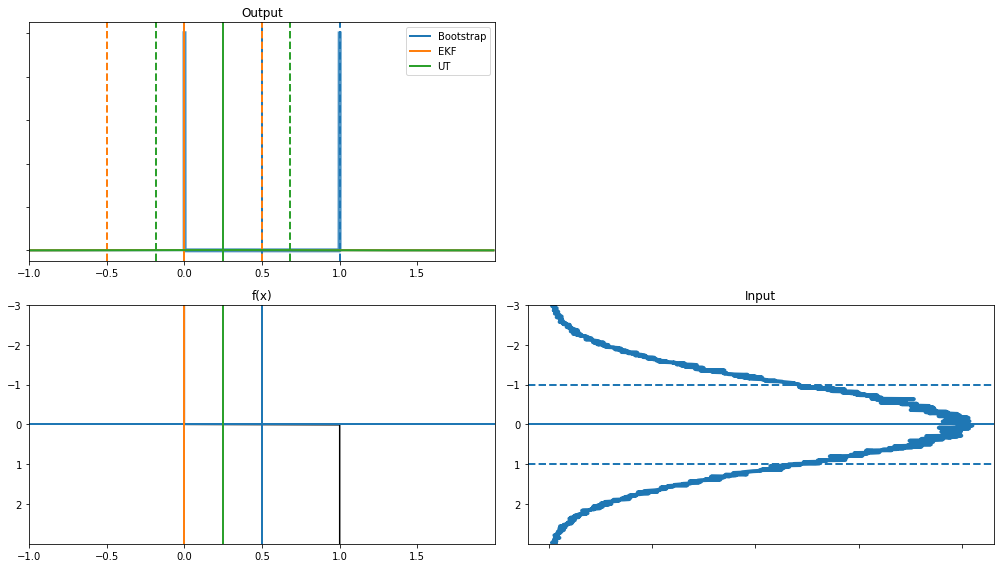

In [12]:
plot_nonlinear_func(normal(loc=0., scale=1., size=500000), lambda x: np.heaviside(x, 0))

Some of sigma points outside of the function domain


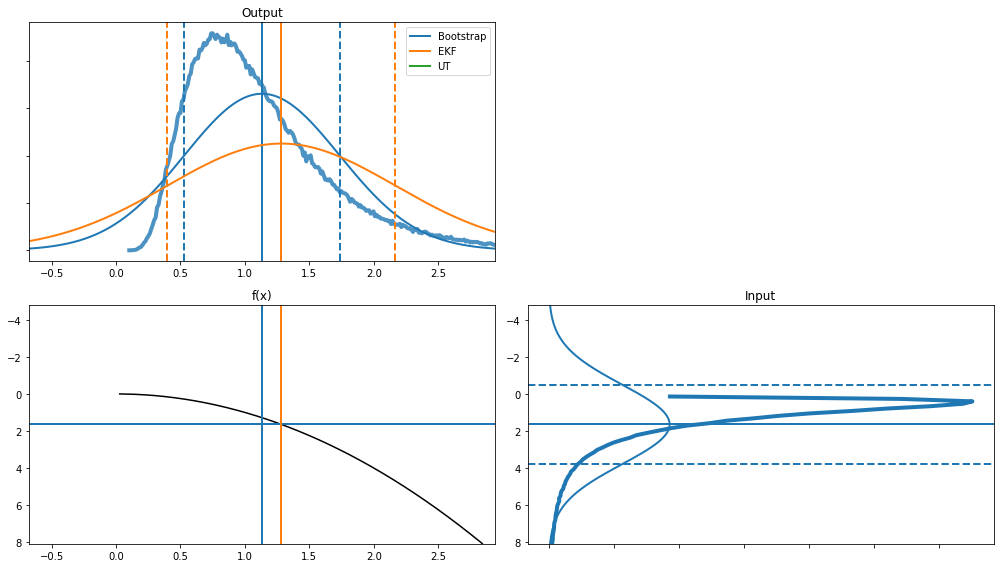

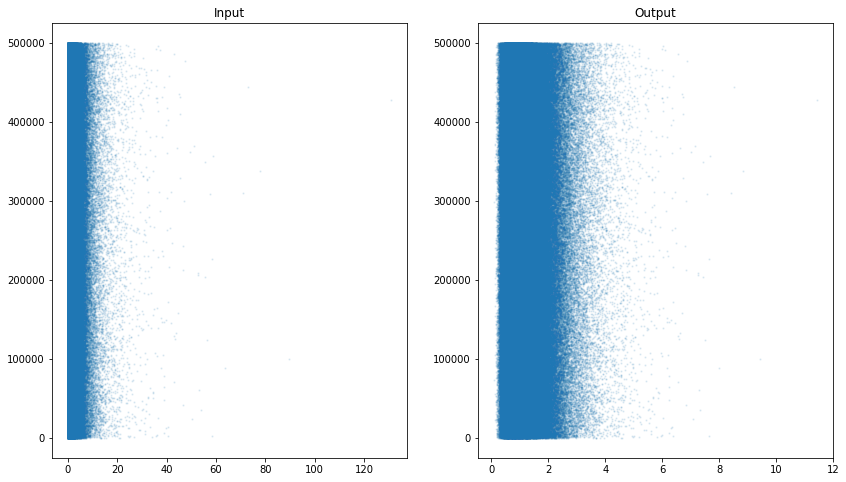

In [13]:
g = lambda x: np.sqrt(x)
plot_nonlinear_func(edata, g)

fig, ax = plt.subplots(1, 2, figsize=(14,8))
ax[0].scatter(edata, range(edata.shape[0]), alpha=.1, s=1.5)
ax[0].set_title('Input')
ax[1].scatter(g(edata), range(edata.shape[0]), alpha=.1, s=1.5);
ax[1].set_title('Output');